# machine learning by graph approach
- database is trained with a graph neural network

In [3]:
import sys
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import datetime

import chainer
from chainer import cuda
chainer.global_config.autotune = True 

sys.path.append("../MIGraph/GraphConv/")
sys.path.append("../MIGraph/Train/")

from GGNN import GGNN
from Config import Config
from AutoParameterScaling import AutoParameterScaling
from GraphNNPredictor import GraphNNPredictor,formatDataset,myConcat

CF=Config()



In [4]:
#load dataset
alldataset= joblib.load("bin/traindataset.bin")

In [5]:
#split dataset using chainer functions
from chainer.iterators import SerialIterator

SPL_RATIO=0.7
miniBatch=32
print("minibatch: ",miniBatch)

split_at = int(len(alldataset) * SPL_RATIO)
trainDataset, testDataset = chainer.datasets.split_dataset_random(alldataset, split_at)

train_iter = SerialIterator(formatDataset(trainDataset), miniBatch)
test_iter = SerialIterator(formatDataset(testDataset),1,False,False)

print("test: ",len(testDataset))
print("train: ",len(trainDataset))

#get labels for prediction
_,_,_,learnLabels=zip(*alldataset)
print("params:", list(set(learnLabels)))

minibatch:  32
test:  94
train:  218
params: ['[s/cm]']


In [6]:
#set up model
from chainer import optimizers
from chainer import training
from chainer.training import extensions


ggnn=GraphNNPredictor()

if CF.GPUMode:
    cuda.get_device(CF.gpu_device).use()
    ggnn.to_gpu(CF.gpu_device)
    print("gpu mode")

#optimizer
optimizer = optimizers.Adam()#alpha=0.0001)
optimizer.setup(ggnn)
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=CF.gpu_device,converter=myConcat)

#trainer (early stopping can be used, but 100 epoch is good)
max_epoch = 100

trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='res')
trainer.extend(extensions.PlotReport(['main/loss','validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.Evaluator(test_iter, ggnn, device=CF.gpu_device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',  'elapsed_time']))


gpu mode


In [7]:
from chainer import serializers

#training
trainer.run()
serializers.save_npz("bin/mymodel.npz", ggnn)


epoch       main/loss   validation/main/loss  elapsed_time
1           3.3893      1.31715               8.27411       
2           2.00611     1.02475               9.43294       
3           1.41871     0.875                 10.5254       
4           1.28589     0.707527              11.6147       
5           0.849498    0.694997              12.6946       
6           1.25546     0.754848              13.7416       
7           1.13197     0.687323              14.8202       
8           1.11782     0.764567              15.8866       
9           1.02997     0.664701              16.9749       
10          1.11953     0.615189              18.0539       
11          0.902245    0.607441              19.102        
12          0.989977    0.59525               20.1947       
13          0.994746    0.62856               21.2862       
14          0.957294    0.621248              22.3751       
15          0.827323    0.588804              23.538        
16          1.00512     0.

In [8]:
from AnalyzeUtility import AnalyzeUtility

#load scalers and data analyzer
autoscaler=joblib.load("praparingGraphs/output/AutoSC.scaler")
analUtil=AnalyzeUtility(autoscaler,ggnn)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.56it/s]


R2:  0.8386006953447497
MAE:  0.18404803


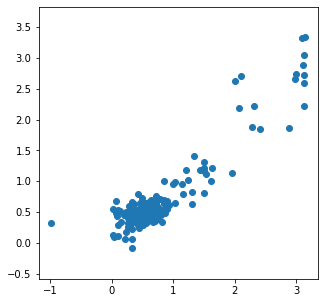

In [9]:
target="[s/cm]"

#train
ggnn.outFingeprint=False
y,t=analUtil.predictByGGNN_batch(formatDataset(trainDataset))
x,y=analUtil.plot(t,y,None,target)



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 79.16it/s]

R2:  0.5501480343271317
MAE:  0.21725896


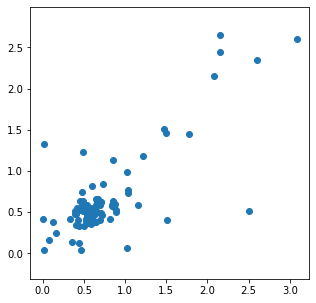

In [10]:
#test
y,t=analUtil.predictByGGNN_batch(formatDataset(testDataset))
x,y=analUtil.plot(t,y,None,target)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 75.69it/s]


<AxesSubplot:>

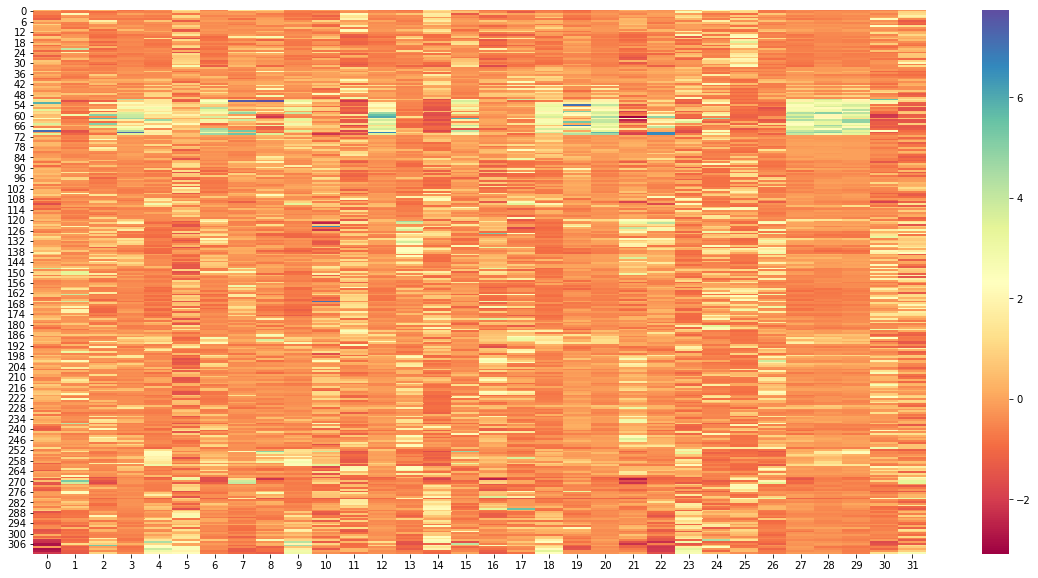

In [11]:
#visualize latent vectors
#check GraphNNPredictor class to see which layer was selected as the internal output

ggnn.outFingeprint=True
trainX,trainY=analUtil.predictByGGNN_batch(formatDataset(alldataset))

sc = StandardScaler()
trainX = sc.fit_transform(trainX)

import seaborn as sns
 
plt.figure(figsize=(20, 10))
sns.heatmap(trainX,cmap="Spectral")